In [1]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp, Statevector


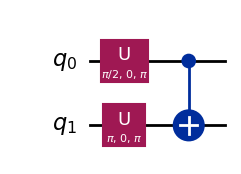

In [2]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.cx(0,1)
psi = Statevector(qc)
qc.decompose().draw(output='mpl')

In [3]:
psi.draw('latex')


<IPython.core.display.Latex object>

In [4]:
# Check the version of Qiskit
import qiskit
 
qiskit.__version__

'2.2.3'

In [5]:
# Import the qiskit library
import numpy as np
import matplotlib.pylab as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.synthesis import (
    SuzukiTrotter,
    LieTrotter,
)

In [6]:
def get_hamiltonian(nqubits, J, h, alpha):
    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, nqubits - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, nqubits)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, nqubits)]
 
    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list(
        [*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=nqubits
    )
    return hamiltonian.simplify()

n_qubits = 6
 
hamiltonian = get_hamiltonian(nqubits=n_qubits, J=0.2, h=1.2, alpha=np.pi / 8.0)
hamiltonian

SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.2       +0.j, -0.2       +0.j,
 -0.2       +0.j, -0.45922012+0.j, -0.45922012+0.j, -0.45922012+0.j,
 -0.45922012+0.j, -0.45922012+0.j, -0.45922012+0.j, -1.10865544+0.j,
 -1.10865544+0.j, -1.10865544+0.j, -1.10865544+0.j, -1.10865544+0.j,
 -1.10865544+0.j])

In [7]:
num_timesteps = 60
evolution_time = 30.0
dt = evolution_time / num_timesteps
product_formula_lt = LieTrotter()

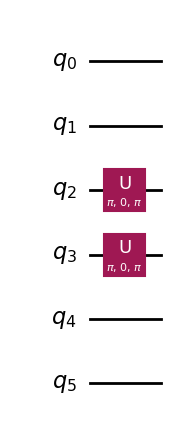

In [8]:
initial_circuit = QuantumCircuit(n_qubits)
initial_circuit.prepare_state("001100")
# Change reps and see the difference when you decompose the circuit
initial_circuit.decompose(reps=2).draw("mpl")


Trotter step with Lie-Trotter
-----------------------------
Depth: 17
Gate count: 27
Nonlocal gate count: 10
Gate breakdown: U: 12, CX: 10, P: 5



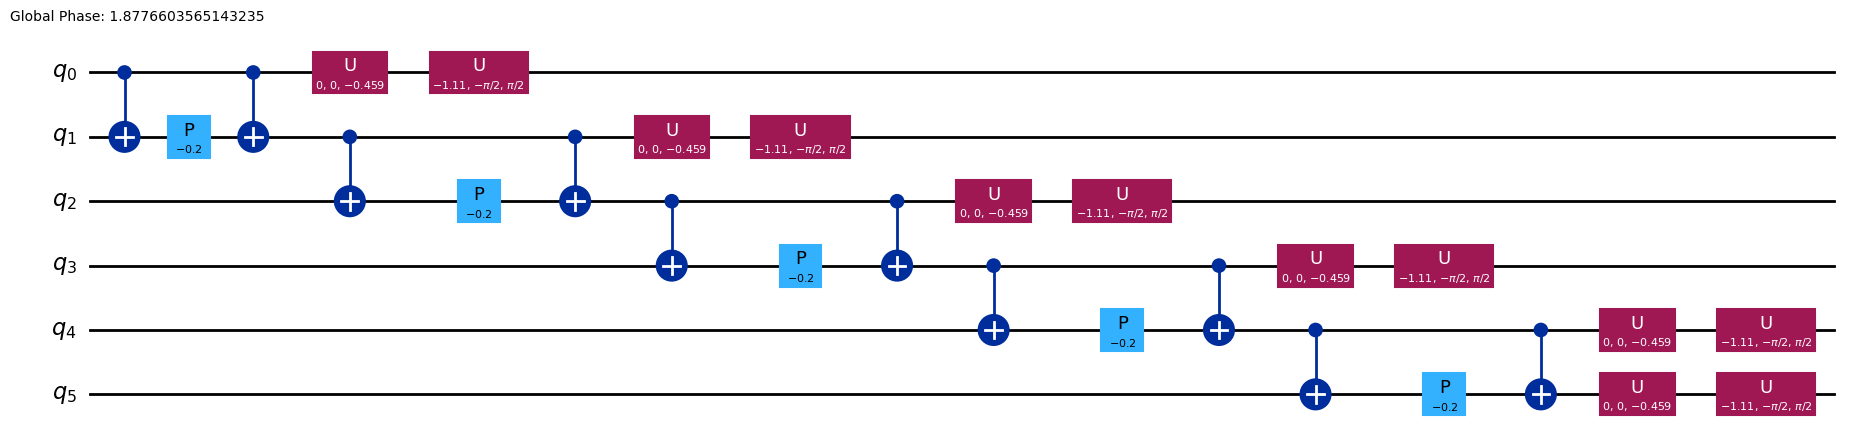

In [9]:
single_step_evolution_gates_lt = PauliEvolutionGate(
    hamiltonian, dt, synthesis=product_formula_lt
)
single_step_evolution_lt = QuantumCircuit(n_qubits)
single_step_evolution_lt.append(
    single_step_evolution_gates_lt, single_step_evolution_lt.qubits
)
 
print(
    f"""
Trotter step with Lie-Trotter
-----------------------------
Depth: {single_step_evolution_lt.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_lt.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_lt.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_lt.decompose(reps=3).count_ops().items()])}
"""
)
single_step_evolution_lt.decompose(reps=3).draw("mpl", fold=-1)

In [10]:
magnetization = (
    SparsePauliOp.from_sparse_list(
        [("Z", [i], 1.0) for i in range(0, n_qubits)], num_qubits=n_qubits
    )
    / n_qubits
)
correlation = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, n_qubits - 1)], num_qubits=n_qubits
) / (n_qubits - 1)
print("magnetization : ", magnetization)
print("correlation : ", correlation)

magnetization :  SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII'],
              coeffs=[0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j,
 0.16666667+0.j, 0.16666667+0.j])
correlation :  SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII'],
              coeffs=[0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j])


In [11]:
# Initiate the circuit
evolved_state = QuantumCircuit(initial_circuit.num_qubits)
# Start from the initial spin configuration
evolved_state.append(initial_circuit, evolved_state.qubits)
# Initiate Estimator (V2)
estimator = StatevectorEstimator()
# Set number of shots
shots = 10000
# Translate the precision required from the number of shots
precision = np.sqrt(1 / shots)
energy_list = []
mag_list = []
corr_list = []
# Estimate expectation values for t=0.0
job = estimator.run(
    [(evolved_state, [hamiltonian, magnetization, correlation])], precision=precision
)
# Get estimated expectation values
evs = job.result()[0].data.evs
energy_list.append(evs[0])
mag_list.append(evs[1])
corr_list.append(evs[2])
# Start time evolution
for n in range(num_timesteps):
    # Expand the circuit to describe delta-t
    evolved_state.append(single_step_evolution_gates_lt, evolved_state.qubits)
    # Estimate expectation values at delta-t
    psi = Statevector(evolved_state)
    print(psi.draw("latex_source"))
    job = estimator.run(
        [(evolved_state, [hamiltonian, magnetization, correlation])],
        precision=precision,
    )
    # Retrieve results (expectation values)
    evs = job.result()[0].data.evs
    energy_list.append(evs[0])
    mag_list.append(evs[1])
    corr_list.append(evs[2])
# Transform the list of expectation values (at each time step) to arrays
energy_array = np.array(energy_list)
mag_array = np.array(mag_list)
corr_array = np.array(corr_list)

/home/takshit/miniconda3/envs/qiskit-latest-env/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/takshit/miniconda3/envs/qiskit-latest-env/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


(-0.0376036362 - 0.1382196975 i) |000000\rangle+(0.0686919459 - 0.0516469263 i) |000001\rangle+(0.067451133 - 0.0546474435 i) |000010\rangle+(0.042072386 + 0.0332186244 i) |000011\rangle+(-0.186608616 + 0.1505476029 i) |000100\rangle+(-0.1255926938 - 0.0706364363 i) |000101\rangle + \ldots +(0.007337137 + 0.0325006759 i) |111011\rangle+(-0.1433931909 - 0.0228822565 i) |111100\rangle+(-0.0191634717 - 0.0851366345 i) |111101\rangle+(-0.0085268799 - 0.0878807277 i) |111110\rangle+(0.0515379499 - 0.0169909068 i) |111111\rangle
(0.0588979165 + 0.0525928214 i) |000000\rangle+(0.0310866282 + 0.0866874434 i) |000001\rangle+(0.0442656864 + 0.0881620022 i) |000010\rangle+(-0.0675612566 + 0.1648163145 i) |000011\rangle+(-0.0275132401 - 0.0468252233 i) |000100\rangle+(-0.0088148308 - 0.0663320457 i) |000101\rangle + \ldots +(0.1609019429 + 0.2015867331 i) |111011\rangle+(-0.0458720597 - 0.0191144829 i) |111100\rangle+(-0.044961319 - 0.042419209 i) |111101\rangle+(-0.0104560732 - 0.0683013502 i) |1

Text(0.5, 0.98, 'Observable evolution')

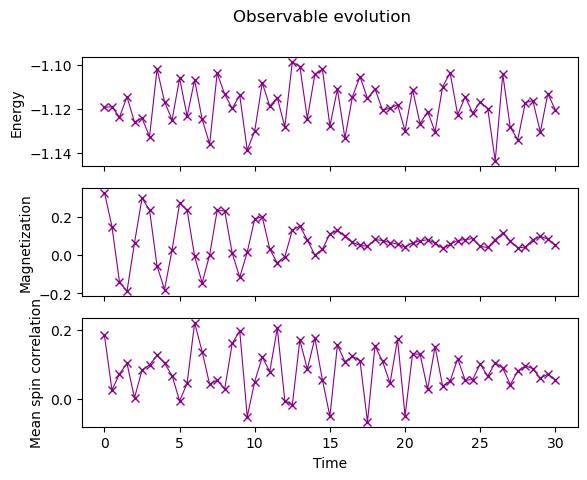

In [12]:
fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, evolution_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times,
    energy_array,
    label="First order",
    marker="x",
    c="darkmagenta",
    ls="-",
    lw=0.8,
)
axes[1].plot(
    times, mag_array, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[2].plot(
    times, corr_array, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")

In [13]:
jcm_hamiltonian = SparsePauliOp(['II','ZI','XX','YY'],[0.5,0.5,2*1.414,1] )
jcm_hamiltonian

SparsePauliOp(['II', 'ZI', 'XX', 'YY'],
              coeffs=[0.5  +0.j, 0.5  +0.j, 2.828+0.j, 1.   +0.j])

In [14]:
num_timesteps = 60
evolution_time = 30.0
dt = evolution_time / num_timesteps
product_formula_lt = LieTrotter()

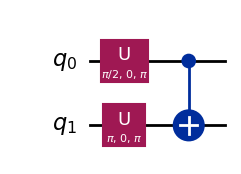

In [15]:
initial_circuit_jcm = qc
qc.decompose(reps=3).draw(output='mpl')


Trotter step with Lie-Trotter
-----------------------------
Depth: 15
Gate count: 23
Nonlocal gate count: 4
Gate breakdown: U: 5, CX: 4, S: 4, H: 4, SDG: 4, P: 2



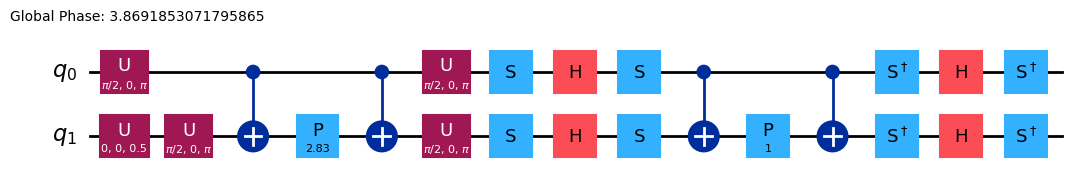

In [16]:
single_step_evolution_gates_lt_jcm = PauliEvolutionGate(
    jcm_hamiltonian, dt, synthesis=product_formula_lt
)
single_step_evolution_lt_jcm = QuantumCircuit(2)
single_step_evolution_lt_jcm.append(
    single_step_evolution_gates_lt_jcm, single_step_evolution_lt_jcm.qubits
)
 
print(
    f"""
Trotter step with Lie-Trotter
-----------------------------
Depth: {single_step_evolution_lt_jcm.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_lt_jcm.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_lt_jcm.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_lt_jcm.decompose(reps=3).count_ops().items()])}
"""
)
single_step_evolution_lt_jcm.decompose(reps=3).draw("mpl", fold=-1)

In [17]:
correlation_jcm = SparsePauliOp(['ZZ'],1)
print("correlation : ", correlation_jcm)

correlation :  SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])


In [18]:
# Initiate the circuit
evolved_state_jcm = QuantumCircuit(initial_circuit_jcm.num_qubits)
# Start from the initial spin configuration
evolved_state_jcm.append(initial_circuit_jcm, evolved_state_jcm.qubits)
# Initiate Estimator (V2)
estimator = StatevectorEstimator()
# Set number of shots
shots = 10000
# Translate the precision required from the number of shots
precision = np.sqrt(1 / shots)
energy_list = []
corr_list = []
# Estimate expectation values for t=0.0
job_jcm = estimator.run(
    [(evolved_state_jcm, [jcm_hamiltonian, correlation_jcm])], precision=precision
)
# Get estimated expectation values
evs = job_jcm.result()[0].data.evs
energy_list.append(evs[0])
corr_list.append(evs[1])
# Start time evolution
for n in range(num_timesteps):
    # Expand the circuit to describe delta-t
    evolved_state_jcm.append(single_step_evolution_gates_lt_jcm, evolved_state_jcm.qubits)
    # Estimate expectation values at delta-t
    job_jcm = estimator.run(
        [(evolved_state_jcm, [jcm_hamiltonian, correlation_jcm])],
        precision=precision,
    )
    # Retrieve results (expectation values)
    evs = job_jcm.result()[0].data.evs
    energy_list.append(evs[0])
    corr_list.append(evs[1])
# Transform the list of expectation values (at each time step) to arrays
energy_array = np.array(energy_list)
corr_array = np.array(corr_list)

Text(0.5, 0.98, 'Observable evolution')

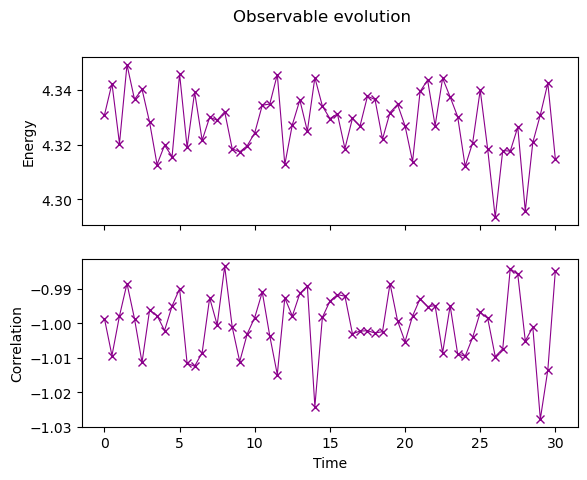

In [19]:
fig, axes = plt.subplots(2, sharex=True)
times = np.linspace(0, evolution_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times,
    energy_array,
    label="First order",
    marker="x",
    c="darkmagenta",
    ls="-",
    lw=0.8,
)

axes[1].plot(
    times, corr_array, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Correlation")
axes[1].set_xlabel("Time")
fig.suptitle("Observable evolution")

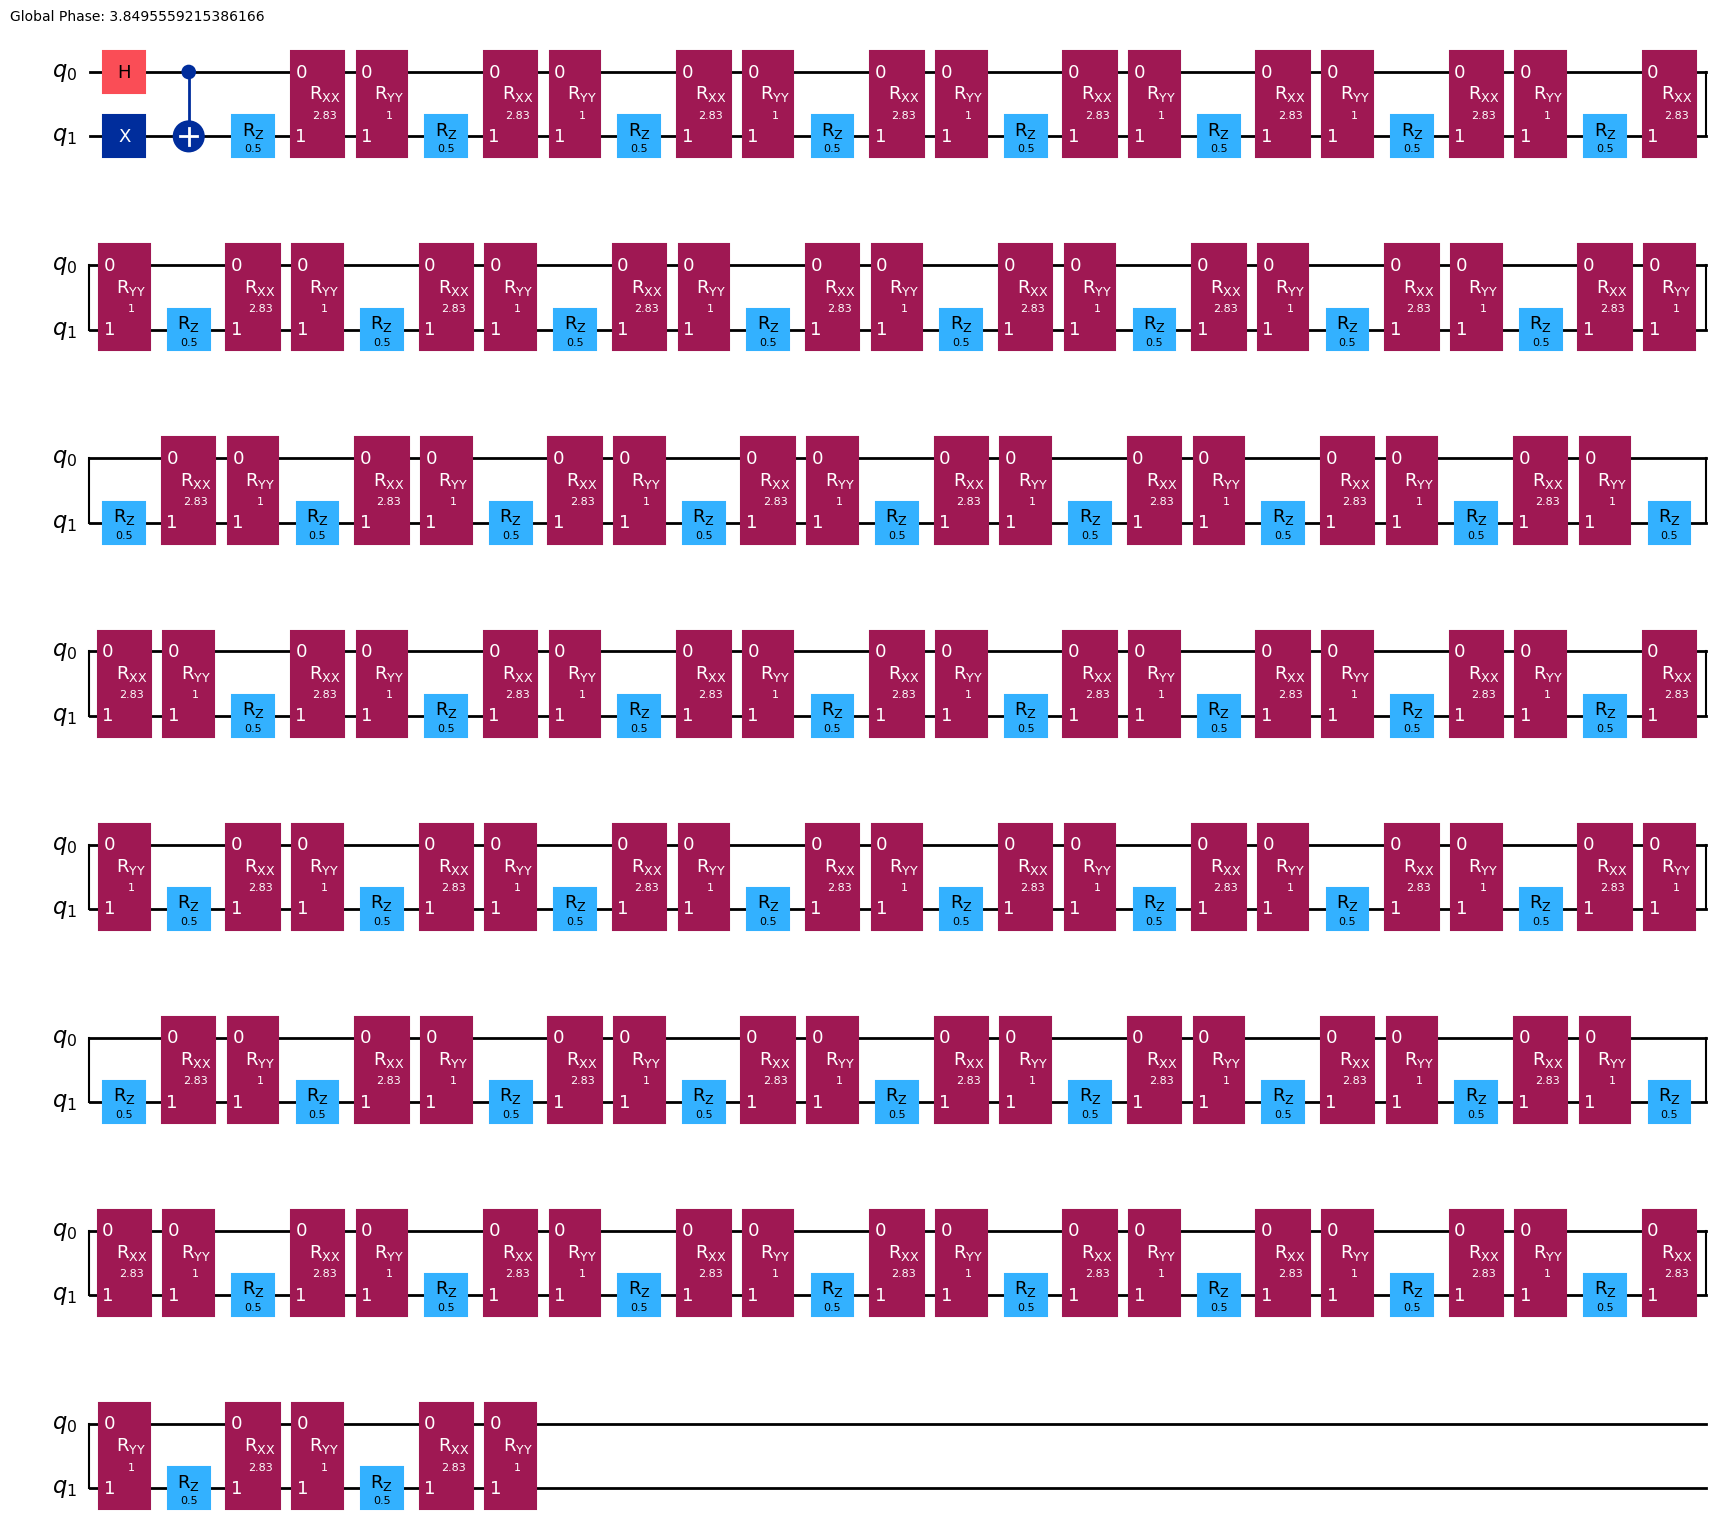

In [20]:
evolved_state_jcm.decompose().draw(output='mpl')